# DDPG算法实现

引包

In [1]:
# import pytorch things
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import other utilities
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

# simulation environment
import gym

参数设置

In [2]:
class Config:
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"  # 检测GPU
    self.state_dim = 3
    self.action_dim = 1
    self.actor_lr = 0.001
    self.critic_lr = 0.001
    self.gamma = 0.99 # reward discount
    self.tau = 0.005 # soft update
    self.batch_size = 64
    self.memory_size = 100000
    self.train_eps = 1000

经验回放池

In [3]:
class ReplayBuffer:
  
  # 经验回放池的数据结构是一个循环队列
  
  def __init__(self, capacity):
    self.capacity = capacity # 经验回放的容量
    self.buffer = [] # 经验回放的缓存
    self.position = 0 # 缓存指针

  def push(self, state, action, reward, next_state, done):
    if len(self.buffer) < self.capacity:
      self.buffer.append(None)
    self.buffer[self.position] = (state, action, reward, next_state, done)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*batch)
    return state, action, reward, next_state, done

  def __len__(self):
    return len(self.buffer)

定义Actor和Critic网络

In [4]:
class Actor(nn.Module):
  def __init__(self, state_dim, action_dim, init_w=3e-3):
    super(Actor, self).__init__()
    self.fc1 = nn.Linear(state_dim, 400)
    self.fc2 = nn.Linear(400, 300)
    self.fc3 = nn.Linear(300, action_dim)

    # initialize the weights and bias
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = torch.tanh(self.fc3(x)) # action output is in [-1, 1]
    return x
  
class Critic(nn.Module):
  def __init__(self, state_dim, action_dim, init_w=3e-3):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(state_dim + action_dim, 400)
    self.fc2 = nn.Linear(400, 300)
    self.fc3 = nn.Linear(300, 1)

    # initialize the weights and bias
    self.fc3.weight.data.uniform_(-init_w, init_w)
    self.fc3.bias.data.uniform_(-init_w, init_w)

  def forward(self, state, action):
    x = torch.cat([state, action], 1) # concatenate the state and action
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

DDPG算法本体

In [5]:
class DDPG:
  def __init__(self, config):
    self.config = config
    self.actor = Actor(config.state_dim, config.action_dim).to(config.device)
    self.actor_target = Actor(config.state_dim, config.action_dim).to(config.device)
    self.actor_target.load_state_dict(self.actor.state_dict()) # initialize the target network with the same weights
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config.actor_lr)

    self.critic = Critic(config.state_dim, config.action_dim).to(config.device)
    self.critic_target = Critic(config.state_dim, config.action_dim).to(config.device)
    self.critic_target.load_state_dict(self.critic.state_dict()) # initialize the target network with the same weights
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config.critic_lr)

    self.memory = ReplayBuffer(config.memory_size)
    self.batch_size = config.batch_size
    self.gamma = config.gamma

  def select_action(self, state):
    state = torch.FloatTensor(state).unsqueeze(0).to(self.config.device)
    return self.actor(state).detach().numpy().flatten()
  
  def update(self):
    if len(self.memory) < self.batch_size:
      return
    
    state, action, reward, next_state, done = self.memory.sample(self.batch_size)
    state = torch.FloatTensor(state).to(self.config.device)
    action = torch.FloatTensor(action).to(self.config.device)
    reward = torch.FloatTensor(reward).to(self.config.device)
    next_state = torch.FloatTensor(next_state).to(self.config.device)
    done = torch.FloatTensor(done).to(self.config.device)

    # update critic
    target_action = self.actor_target(next_state)
    target_value = reward + (1 - done) * self.gamma * self.critic_target(next_state, target_action)
    critic_loss = F.mse_loss(self.critic(state, action), target_value)
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()

    # update actor
    actor_loss = -self.critic(state, self.actor(state)).mean()
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()

    # soft update target networks
    for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      target_param.data.copy_(self.config.tau * param.data + (1 - self.config.tau) * target_param.data)
    for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
      target_param.data.copy_(self.config.tau * param.data + (1 - self.config.tau) * target_param.data)

DDPG训练过程

In [6]:
def train(agent, env, config):
  total_reward = []

  for eps in range(config.train_eps):
    # reset environment and get initial state
    state = env.reset()
    state = state[0] # gym returns a tuple, we only need the first element
    episode_reward = 0
    done = False

    # start training
    while not done:
      action = agent.select_action(state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      reward = np.array([reward]) # convert to numpy array to match the type of state and action
      done = np.array([done]) # convert to numpy array to match the type of state and action
      agent.memory.push(state, action, reward, next_state, done) # store the transition in memory
      episode_reward += reward
      state = next_state
      agent.update()

    total_reward.append(episode_reward)
    print(f"Episode: {eps+1}, reward: {episode_reward}")

  return total_reward

展示reward相关画图函数

In [7]:
def plot_rewards(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Cumulative Reward')
    plt.plot(pd.Series(rewards).rolling(window=100).mean(), label='Moving Average Reward', color='orange')
    plt.title('Cumulative Reward and Moving Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

主函数

/usr/anaconda3/envs/rl-playground/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_84934/2985586745.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580401398/work/torch/csrc/utils/tensor_new.cpp:274.)
  state = torch.FloatTensor(state).to(self.config.device)


Episode: 1, reward: [-971.5221727]
Episode: 2, reward: [-1445.88341388]
Episode: 3, reward: [-1555.53407932]
Episode: 4, reward: [-1690.34771726]
Episode: 5, reward: [-1572.44727058]
Episode: 6, reward: [-1532.23991933]
Episode: 7, reward: [-1466.0322208]
Episode: 8, reward: [-1405.55214846]
Episode: 9, reward: [-1343.5954318]
Episode: 10, reward: [-1127.48315732]
Episode: 11, reward: [-1403.03405629]
Episode: 12, reward: [-1383.95787012]
Episode: 13, reward: [-1470.51521334]
Episode: 14, reward: [-986.89184021]
Episode: 15, reward: [-1104.80205923]
Episode: 16, reward: [-1266.18911811]
Episode: 17, reward: [-1280.8437723]
Episode: 18, reward: [-1098.28950873]
Episode: 19, reward: [-1126.80427867]
Episode: 20, reward: [-1203.65965027]
Episode: 21, reward: [-838.38540186]
Episode: 22, reward: [-1011.58194222]
Episode: 23, reward: [-1091.03327949]
Episode: 24, reward: [-1130.45631878]
Episode: 25, reward: [-1075.84004471]
Episode: 26, reward: [-997.90293131]
Episode: 27, reward: [-928.74

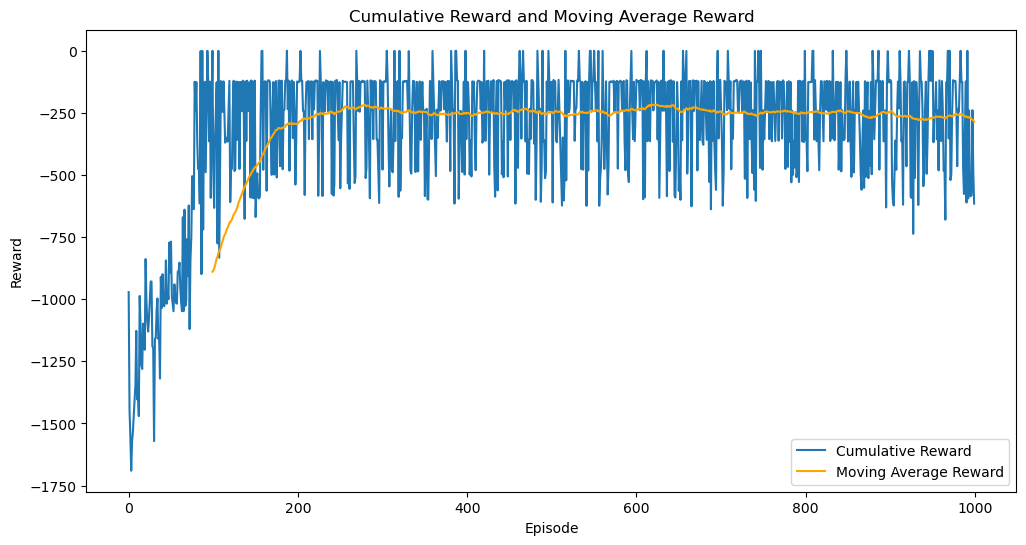

In [8]:
if __name__ == "__main__":
    config = Config()
    env = gym.make("Pendulum-v1")
    agent = DDPG(config)
    rewards = train(agent, env, config)
    plot_rewards(rewards)